<a href="https://colab.research.google.com/github/Victor0vich/Denis/blob/main/Image_Classification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение моделей в PyTorch

Для того, чтобы разобраться как обучать нейросети в **PyTorch**, нужно освоить три вещи:

1. Как формировать батчи и подавать их на вход сети
2. Как задать архитектуру сети
3. Как написать цикл обучения и отслеживать метрики

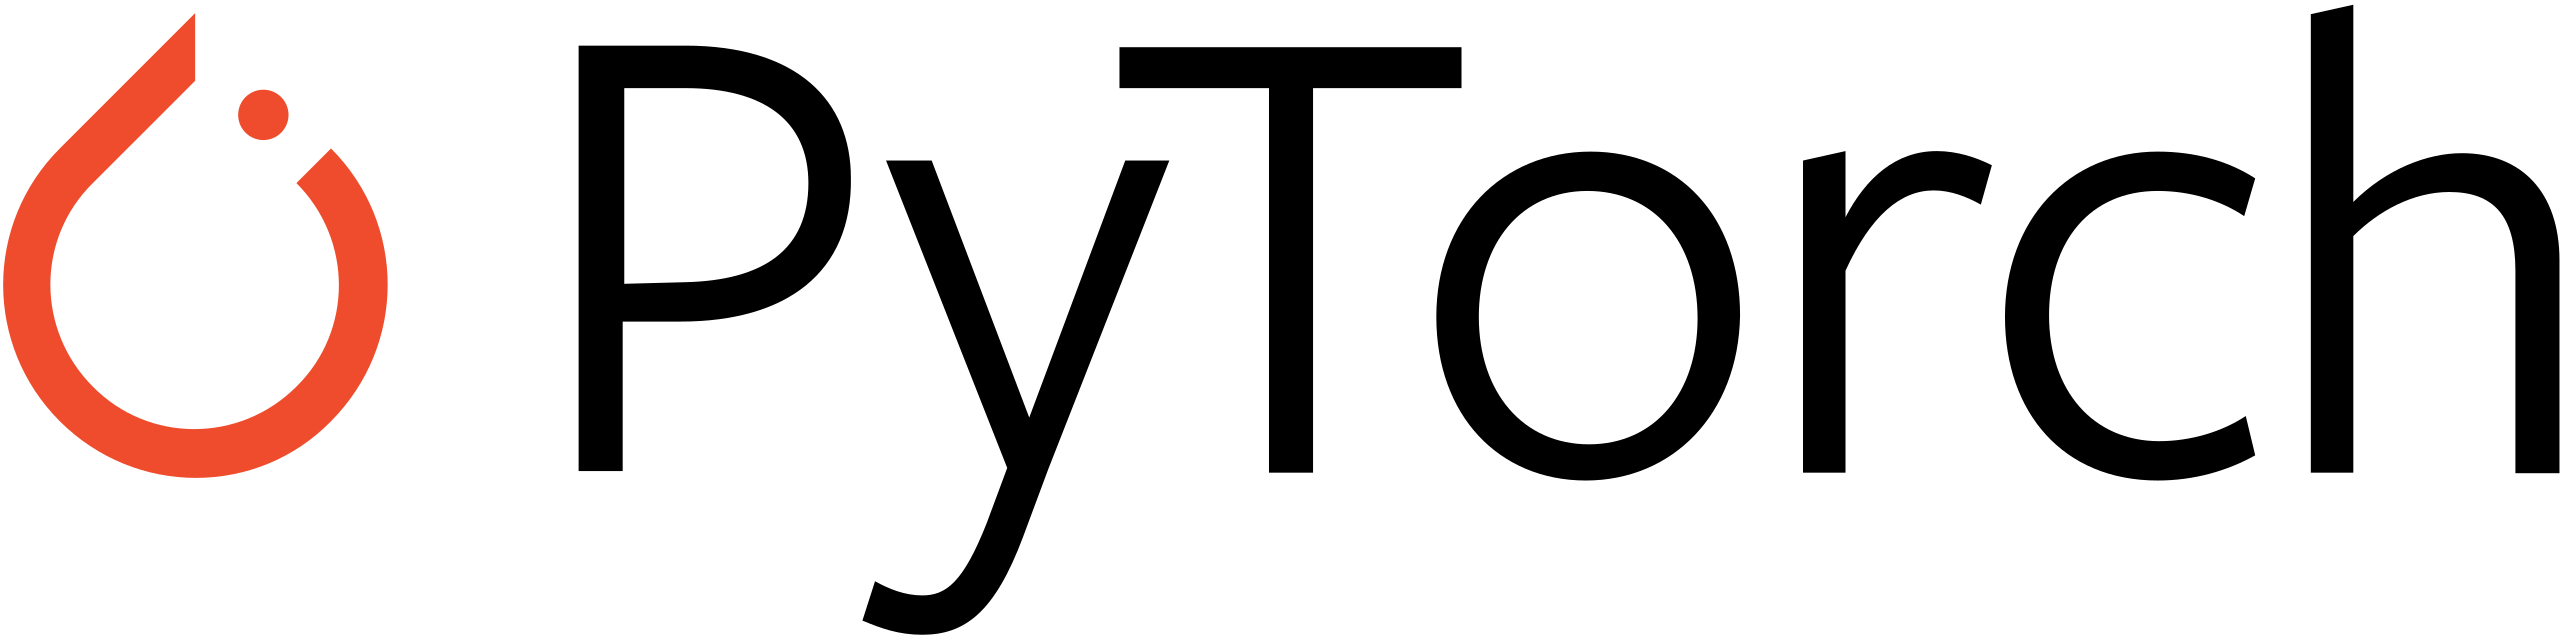

### 1. Как формировать батчи и подавать их на вход нейросети

Чтобы иметь возможность итерироваться по данным и применять к ним преобразования (например, аугментации, о которых вы узнаете позже), нужно создать свой класс унаследованный от `torch.utils.data.Dataset`.

У такого класса **должно быть** три метода:

* `__init__` — создаёт поля класса (например, путь к папке с файлами с тренировочными объектами)
* `__len__` — возвращает информацию о том, сколько объектов у нас в датасете
* `__getitem__` — по индексу возвращает семпл и таргет к нему


Давайте напишем такой сами, в качестве данных используя случайные значения.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from tqdm.notebook import tqdm

%matplotlib inline

In [ ]:
class RandomDataset(torch.utils.data.Dataset):
    """
    Our random dataset
    """

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {
            "sample": torch.tensor(self.x[idx, :], dtype=torch.float),
            "target": self.y[idx],
        }

In [ ]:
x = np.random.rand(1000, 5)
y = np.random.rand(1000)

In [ ]:
our_dataset = RandomDataset(x, y)

In [ ]:
our_dataset.__getitem__(1)

{'sample': tensor([0.4621, 0.9324, 0.4342, 0.3084, 0.5815]),
 'target': 0.4015690019831767}

### Даталоадер

Для того, чтобы из данных получать батчи в pytorch используется такая сущность как даталоадер, который принимает на вход класс унаследованный от `torch.utils.data.Dataset`. Сейчас посмотрим на пример:

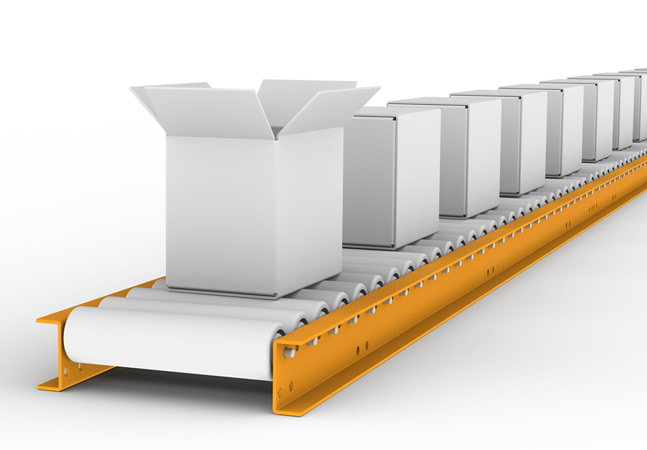

In [ ]:
dataloader = torch.utils.data.DataLoader(our_dataset, batch_size=4)

Работают с ним следующим образом:

In [ ]:
batch = next(iter(dataloader))

print(f"Sample:\n{batch['sample']}")
print(f"Target:\n{batch['target']}")

Sample:
tensor([[0.1609, 0.1437, 0.4865, 0.2441, 0.4511],
        [0.4621, 0.9324, 0.4342, 0.3084, 0.5815],
        [0.7469, 0.5433, 0.3226, 0.0552, 0.0712],
        [0.8682, 0.6060, 0.8044, 0.4314, 0.8920]])
Target:
tensor([0.5759, 0.4016, 0.1016, 0.7939], dtype=torch.float64)


### 2. Как задать архитектуру сети

Для того, чтобы в high-level **PyTorch** создавать нейросети, используется модуль `torch.nn`. Нейросеть должна быть унаследована от класса `nn.Module`. Пример как это может выглядеть:

```
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
       x = F.relu(self.conv1(x))
       return F.relu(self.conv2(x))
```

Как мы видим на данном примере, у данного класса **должен быть** метод `forward`, который определяет прямой проход нейросети. Также из класса выше видно, что модуль `nn` содержит в себе реализацию большинства слоев, а модуль `nn.functional` -- функций активаций.

Есть еще один способ создать нейросеть и давайте его разберем на практике:

In [ ]:
model = nn.Sequential()  # создаем пустую модель, в которую будем добавлять слои
model.add_module(
    "l1", nn.Linear(5, 30)
)  # добавили слой с 5-ю нейронами на вход и 3-мя на выход
model.add_module("l2", nn.ReLU())  # добавили функцию активации
model.add_module(
    "l3", nn.Linear(30, 1)
)  # добавили слой с 3-мя нейронами на вход и 5-ю на выход

# альтернативный способ
another_model = nn.Sequential(nn.Linear(5, 30), nn.ReLU(), nn.Linear(30, 1))

In [ ]:
y_pred = model(batch["sample"])  # получили предсказания модели

### 3. Как написать цикл обучения и отслеживать метрики

Давайте соберем вместе загрузку данных, создание модели и обучим на уже созданном для нас датасете MNIST

In [ ]:
# используем готовый класс от торча для загрузки данных для тренировки
mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

# так как это уже унаследованный от Dataset класс, его можно сразу обернуть в даталоадер
train_dataloader = torch.utils.data.DataLoader(
    mnist_train, batch_size=4, shuffle=True, num_workers=1
)

val_dataloader = torch.utils.data.DataLoader(
    mnist_val, batch_size=4, shuffle=False, num_workers=1
)

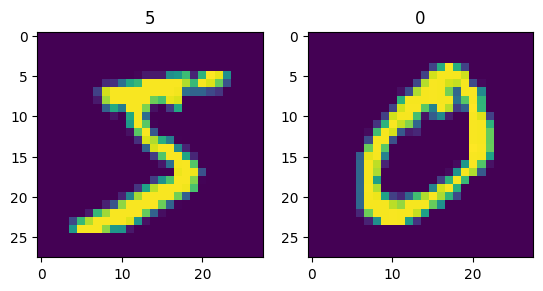

In [ ]:
# посмотрим на то, с чем мы работаем
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
plt.show()

Начнем с простейшей полносвязной сети

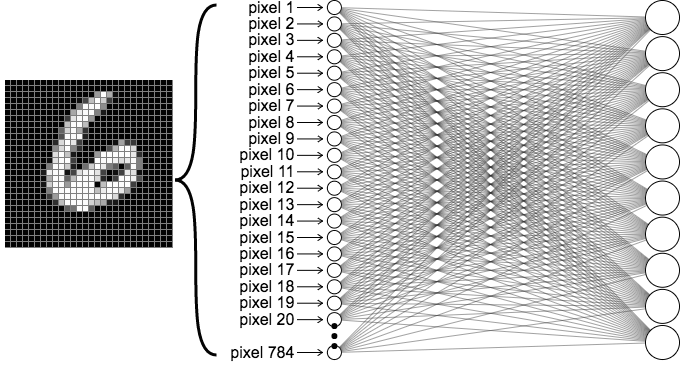

In [ ]:
model = nn.Sequential(
    nn.Flatten(),  # превращаем картинку 28х28 в вектор размером 784
    nn.Linear(
        28 * 28, 128
    ),  # линейный слой, преобразующий вектор размера 784 в вектор размера 128
    nn.ReLU(),  # нелинейность
    nn.Linear(
        128, 10
    ),  # линейный слой, преобразующий вектор размера 128 в вектор размера 10
)

# создаем оптимизатор, который будет обновлять веса модели
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

Веса моделей хранятся в виде матриц и выглядят так:

In [ ]:
[x for x in model.named_parameters()]

[('1.weight',
  Parameter containing:
  tensor([[-0.0022,  0.0331, -0.0354,  ..., -0.0327,  0.0124, -0.0304],
          [ 0.0085, -0.0028, -0.0215,  ...,  0.0016, -0.0176,  0.0106],
          [ 0.0078, -0.0034, -0.0049,  ...,  0.0093, -0.0126, -0.0184],
          ...,
          [ 0.0327,  0.0321, -0.0155,  ..., -0.0122,  0.0006,  0.0199],
          [ 0.0182,  0.0151,  0.0255,  ..., -0.0217,  0.0153,  0.0014],
          [ 0.0034,  0.0290,  0.0054,  ..., -0.0274,  0.0300, -0.0347]],
         requires_grad=True)),
 ('1.bias',
  Parameter containing:
  tensor([-2.8668e-02,  5.1334e-03,  2.8632e-03, -1.9725e-02, -8.7137e-03,
          -2.7498e-03, -1.4690e-02, -3.5300e-02,  1.4773e-02, -1.3868e-02,
           2.3669e-02,  1.9498e-02,  2.6774e-02,  1.8703e-02, -2.1834e-02,
           2.3649e-02,  2.1808e-02, -1.2060e-02, -3.9950e-03,  3.4421e-02,
           1.6752e-02, -8.4129e-03,  3.3608e-02,  2.0886e-02, -1.7242e-02,
          -2.8234e-02,  2.4769e-02,  3.4918e-02, -2.3402e-02, -2.4203e-0

Одним из основных преимуществ PyTorch является возможность использования GPU-ускорителей на CUDA-совместимых графических процессорах Nvidia Compute Unified Device Architecture (CUDA) и Apple Metal Performance Shaders (MPS). До сих пор все, что мы делали, было на процессоре.

Во-первых, мы должны проверить, доступен ли графический процессор, с помощью метода ```is_available()```. Если у вас не установлен CUDA-совместимый графический процессор и драйверы CUDA, то после исполнения ячейки ниже в качестве девайса будет выступать CPU.

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Как только мы определили, что один или несколько графических процессоров доступны, нам нужно поместить наши данные туда, где графический процессор сможет их увидеть. Ваш процессор выполняет вычисления над данными в оперативной памяти вашего компьютера. К вашему графическому процессору подключена выделенная память. Всякий раз, когда вы хотите выполнить вычисление на устройстве, вы должны переместить все данные, необходимые для этого вычисления, в память, доступную этому устройству.

По умолчанию новые тензоры создаются на CPU, поэтому нам нужно указать, когда мы хотим создать наш тензор на графическом процессоре, с помощью необязательного аргумента устройства.

In [ ]:
x = torch.rand(2, 2, device=device)
x

tensor([[0.2376, 0.7058],
        [0.5861, 0.7162]])

Чтобы выполнять вычисления с использованием двух или более тензоров, все тензоры должны находиться на одном устройстве.

Если у вас уже есть тензор, расположенный на одном устройстве, вы можете переместить его на другое с помощью метода ```to()```.
Перенесем созданную ранее модель на наш новый девайс.

In [ ]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
)

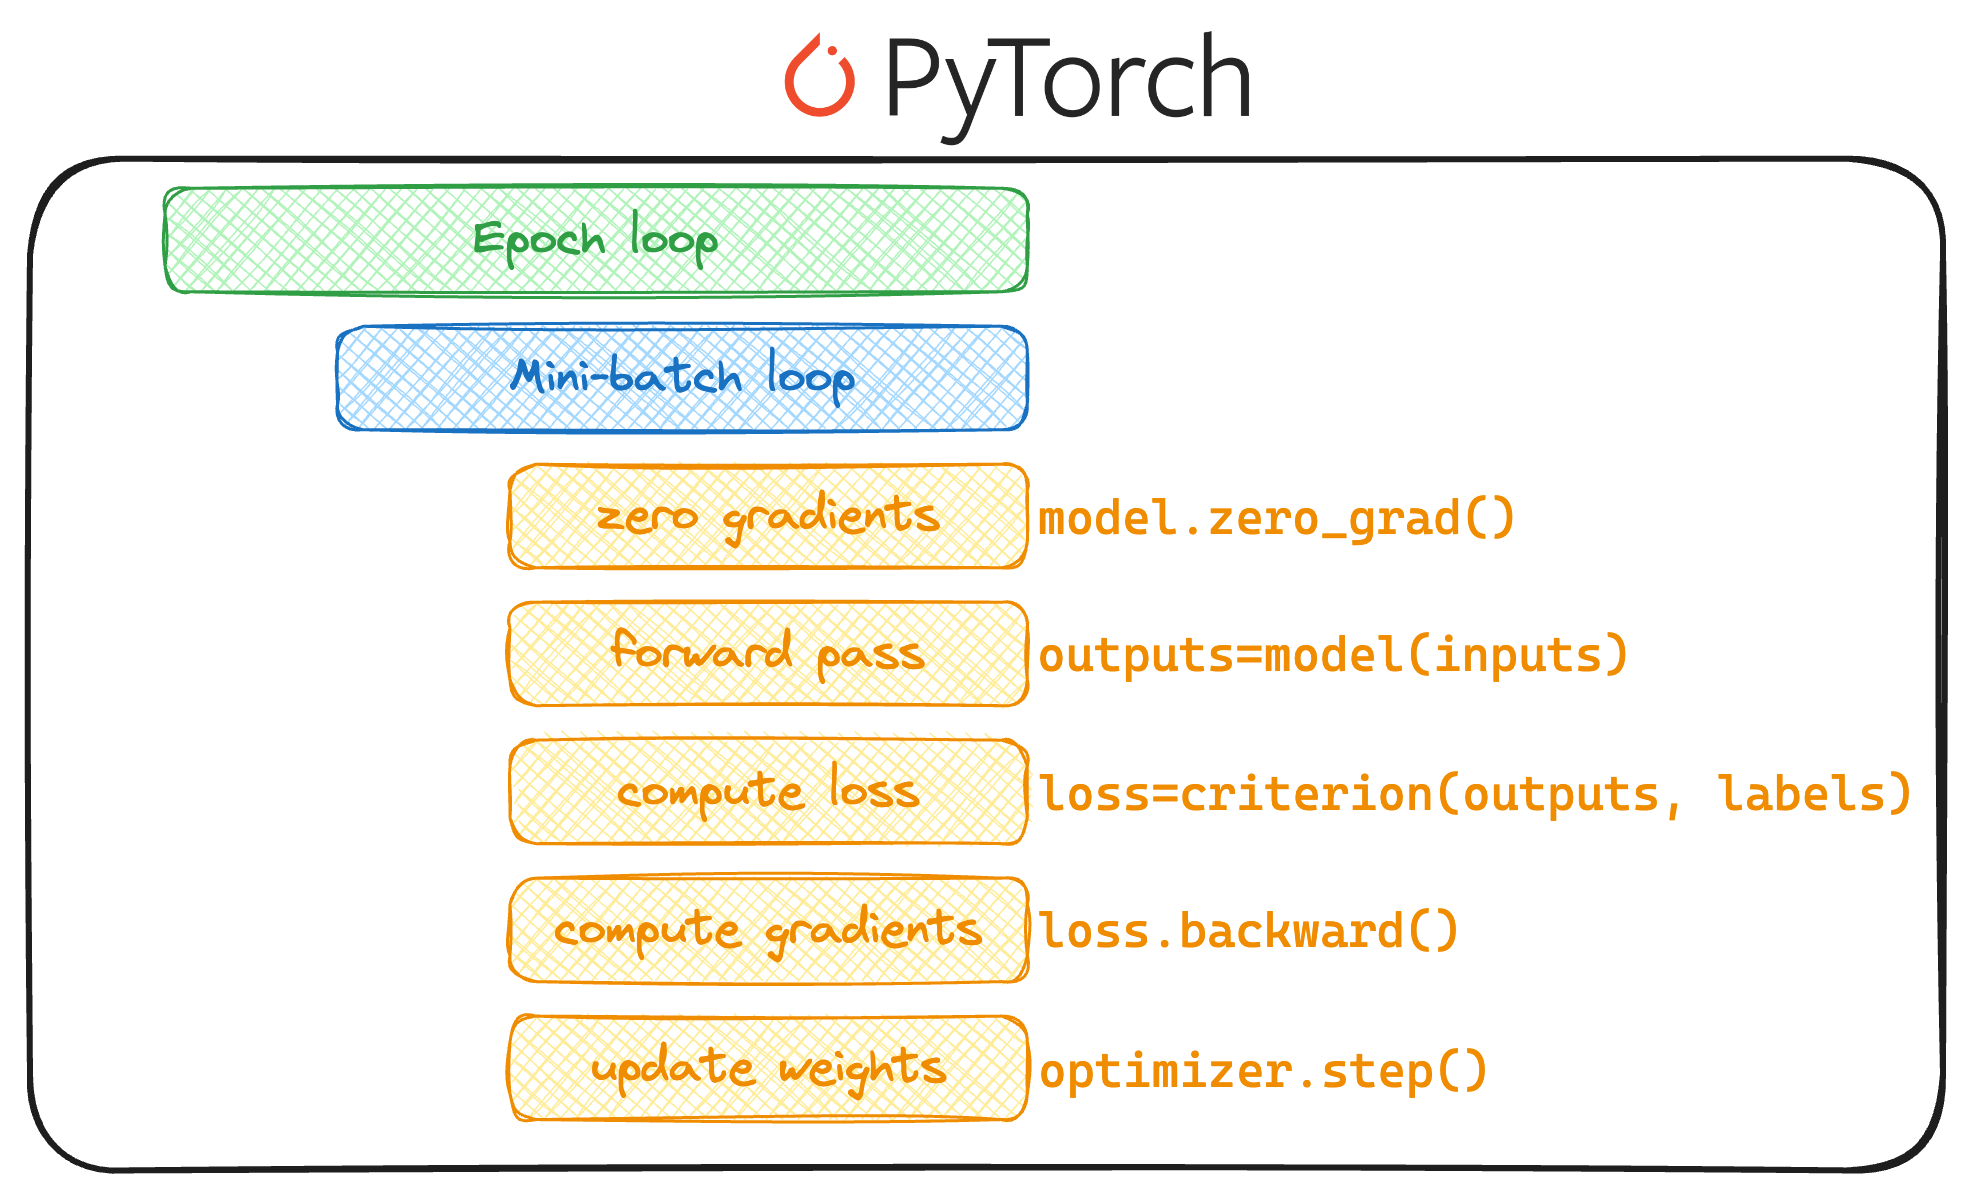

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

train_losses = []
val_losses = []
val_accuracies = []

# всего у нас будет 5 эпох (5 раз подряд пройдемся по всем батчам из трейна)
for epoch in range(3):
    epoch_train_loss = []
    for x_train, y_train in tqdm(train_dataloader):  # берем батч из трейн лоадера
        y_pred = model(x_train.to(device))  # делаем предсказания
        loss = F.cross_entropy(y_pred, y_train.to(device))  # считаем лосс
        loss.backward()  # считаем градиенты обратным проходом
        optimizer.step()  # обновляем параметры сети
        optimizer.zero_grad()  # обнуляем посчитанные градиенты параметров
        epoch_train_loss.append(loss.item())

    train_losses.append(np.mean(epoch_train_loss))

    val_loss = []  # сюда будем складывать **средний по батчу** лосс
    val_accuracy = []
    with torch.no_grad():  # на валидации запрещаем фреймворку считать градиенты по параметрам
        for x_val, y_val in tqdm(val_dataloader):  # берем батч из валидационного лоадера
            y_pred = model(x_val.to(device))  # делаем предсказания
            loss = F.cross_entropy(y_pred, y_val.to(device))  # считаем лосс
            val_loss.append(loss.cpu().numpy())  # добавляем в массив
            val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val.to(device)).cpu().numpy().tolist())

    val_losses.append(np.mean(val_loss))
    val_accuracies.append(np.mean(val_accuracy))

    # печатаем метрики
    print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

  1%|          | 179/15000 [00:01<02:13, 111.36it/s]


KeyboardInterrupt: 

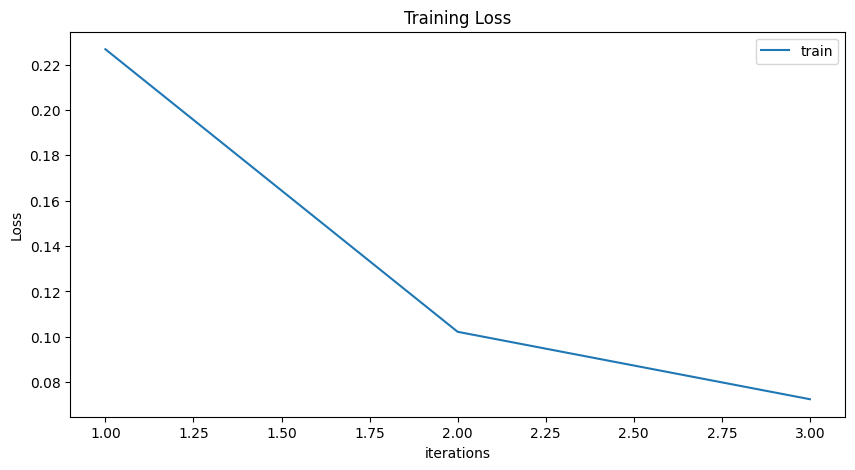

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(np.arange(1,len(train_losses)+1), train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

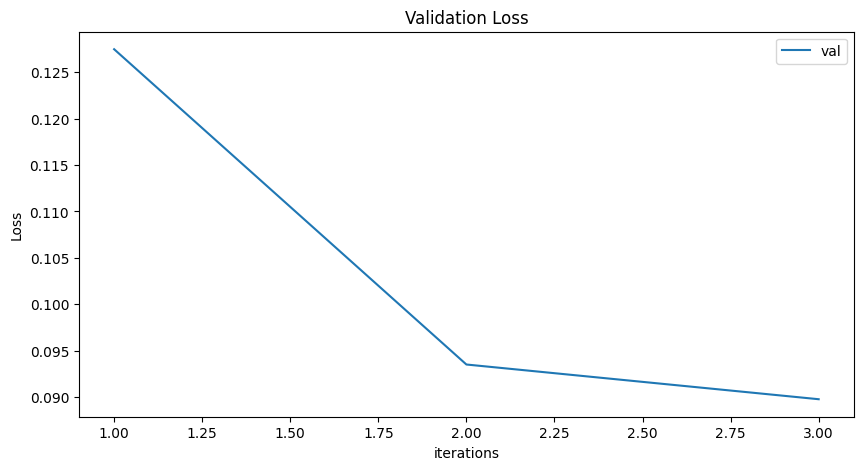

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation Loss")
plt.plot(np.arange(1,len(val_losses)+1), val_losses,label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Классификация изображений и сверточные слои в PyTorch

Обернем цикл обучения в функцию

In [ ]:
def train(model, optimizer, n_epochs=5):
    """Функция, в которой проходит обучение нейросети.

    Parameters
    ----------
    model : nn.Module
        Нейросеть для обучения.
    optimizer : torch.optim.Optimizer
        Алгоритм оптимизации гиперпараметров (например, SGD)
    n_epochs : int, default 5
        Количество эпох для обучения нейросети. Эпоха – проход по объектам
        датасета алгоритмом оптимизации с обновлением гиперпараметров.
    """

    for epoch in range(n_epochs):
        # тренировка
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []

            # отключается весь функционал расчета градиентов
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend(
                        (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
                    )

            # печатаем метрики
            print(
                f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}"
            )

Усложним архитектуру, добавив в неё свёрточные слои.

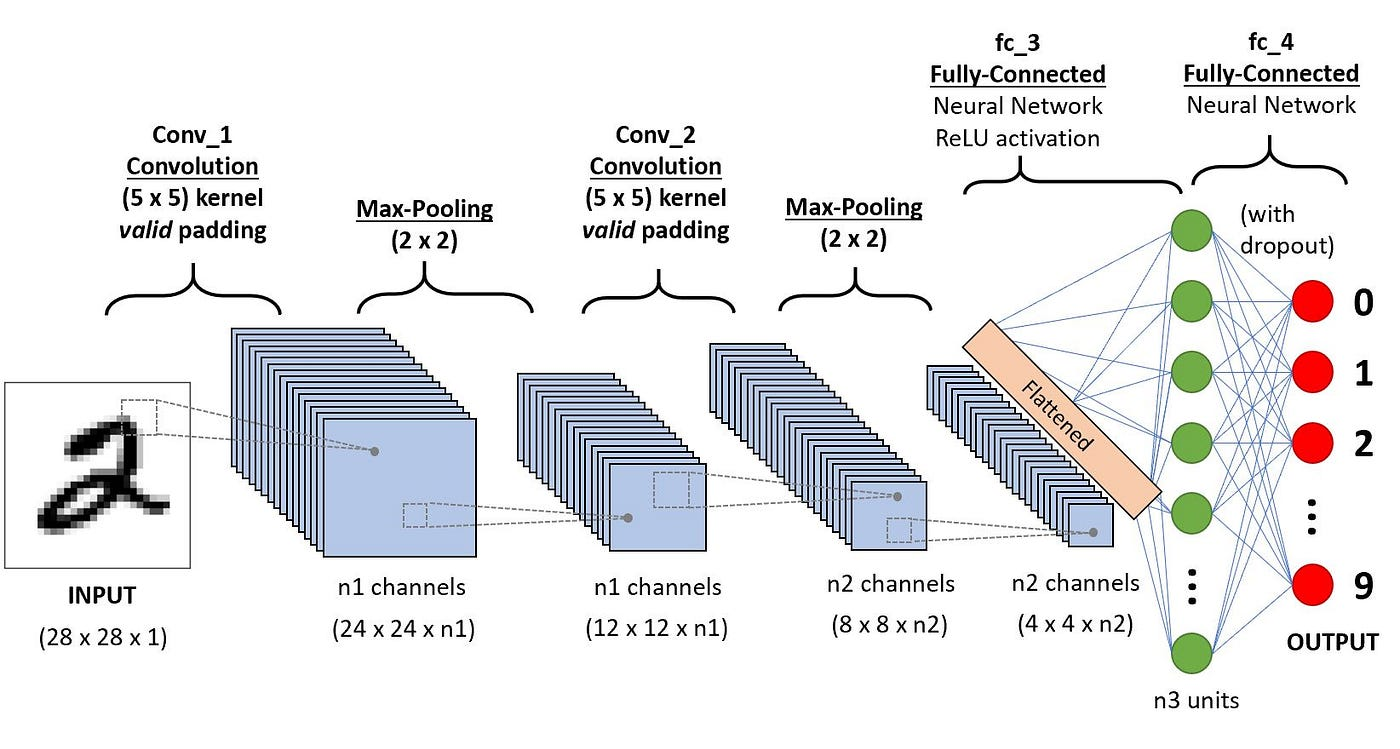

In [ ]:
model = nn.Sequential(
    nn.Conv2d(
        in_channels=1, out_channels=10, kernel_size=5
    ),  # добавим свёрточный слой с 10 ядрами
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),  # уменьшим картинку в 4 раза по каждой стороне
    nn.Flatten(),  # превращаем картинку 6х6х10 в вектор размером 360
    nn.Linear(
        6 * 6 * 10, 128
    ),  # линейный слой, преобразующий вектор размера 360 в вектор размера 128
    nn.ReLU(),  # нелинейность
    nn.Linear(
        128, 10
    ),  # отображение в пространство размерности числа меток классификации
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
print(
    f"Training model with {sum([x[1].numel() for x in model.named_parameters()])} parameters"
)
train(model, optimizer)

Training model with 47758 parameters


100%|██████████| 2500/2500 [00:08<00:00, 279.16it/s]


Epoch: 0, loss: 0.07781744003295898, accuracy: 0.9756


100%|██████████| 2500/2500 [00:08<00:00, 288.28it/s]


Epoch: 2, loss: 0.04339116811752319, accuracy: 0.9864


100%|██████████| 2500/2500 [00:07<00:00, 315.23it/s]

Epoch: 4, loss: 0.04508684575557709, accuracy: 0.9846


По аналогии с предыдущим примером, обучим нейронную сеть, у которой будут следующие слои:

- Свёрточный слой с 10 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Свёрточный слой с 20 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Полносвязный слой со 128 нейронами
- Функция активации ReLU
- Выходной слой

In [ ]:
# 1-й способ
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(4 * 4 * 20, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [ ]:
# 2-й способ
class ConvNetMNIST(nn.Module):

    def __init__(self):
        """Создание объекта класса. Через дополнительные аргументы можно
        изменять параметры слоев сети."""
        # инициализируем родителя
        super().__init__()

        # записываем в атрибуты составные части сети
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv_2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.relu = nn.ReLU()  # используется 3 раза
        self.pool = nn.MaxPool2d(kernel_size=2)  # используется 2 раза
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(4 * 4 * 20, 128)
        self.fc_2 = nn.Linear(128, 10)

    def forward(self, x : torch.tensor) -> torch.tensor:
        """Прямой проход по нейронной сети. Вычисление предсказаний."""
        pred = self.conv_1(x)
        pred = self.relu(pred)
        pred = self.pool(pred)
        pred = self.conv_2(pred)
        pred = self.relu(pred)
        pred = self.pool(pred)
        pred = self.flatten(pred)
        pred = self.fc_1(pred)
        pred = self.relu(pred)
        pred = self.fc_2(pred)

        return pred

model = ConvNetMNIST()

Код, написанный первым способом, более краткий и легче читается. Однако не все архитектуры можно представить в виде последовательного применения операторов из `torch.nn`. Также некоторые операторы могут повторяться. Поэтому чаще нейросеть записывается именно вторым способом, с помощью класса-наследника `nn.Module`.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
print(
    f"Training model with {sum([x[1].numel() for x in model.named_parameters()])} parameters"
)

train(model, optimizer)

Training model with 47658 parameters


  4%|▍         | 631/15000 [00:05<01:56, 123.87it/s]


KeyboardInterrupt: 